<a href="https://colab.research.google.com/github/JulianGlatzer/HplusML/blob/master/MassParameterisedNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Standard imports

In [18]:
! rm -rf HplusML
! wget https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_ge6jge4b.h5

--2019-03-20 14:41:18--  https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_ge6jge4b.h5
Resolving jglatzer.web.cern.ch (jglatzer.web.cern.ch)... 188.184.64.89, 2001:1458:201:a4::100:53
Connecting to jglatzer.web.cern.ch (jglatzer.web.cern.ch)|188.184.64.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51165780 (49M) [text/plain]
Saving to: ‘pandas_INC_ge6jge4b.h5.1’

pandas_INC_ge6jge4b 100%[===================>]  48.79M  12.8MB/s    in 9.8s    

2019-03-20 14:41:28 (4.97 MB/s) - ‘pandas_INC_ge6jge4b.h5.1’ saved [51165780/51165780]



In [19]:
! git clone https://github.com/JulianGlatzer/HplusML
import sys
sys.path.append("HplusML")
!cd HplusML; git pull origin

Cloning into 'HplusML'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 203 (delta 108), reused 141 (delta 55), pack-reused 0
Receiving objects: 100% (203/203), 3.52 MiB | 9.17 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Already up to date.


In [0]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpAlgorithms
import HpMLUtils
import HpKerasUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame

In [21]:
df_mc=pd.read_hdf('pandas_INC_ge6jge4b.h5', 'INC_ge6jge4b')
df_mc=df_mc[df_mc.process.apply(lambda x: True if x in ["ttlight","ttb","ttc"] or "Hp" in x else False)]
#print df_mc.process.shape
df_mc['process'].unique()

array(['ttlight', 'ttc', 'ttb', 'Hp200', 'Hp225', 'Hp250', 'Hp275',
       'Hp300', 'Hp350', 'Hp400', 'Hp500', 'Hp600', 'Hp700', 'Hp800',
       'Hp900', 'Hp1000', 'Hp1200', 'Hp1400', 'Hp1600', 'Hp1800',
       'Hp2000'], dtype=object)

# Prepare data for parameterised H+ classification

split into test and training data

In [26]:
from HpMLUtils import WeightedStandardScaler, summarizeFitData,MultiSBWeightsScaler
htf=HpTrainingFrame.HpTrainingFrame(df_mc)
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass="multi",addMass=True)
#summarizeFitData(X_train, y_train, w=w_train,categories=X_train.hpmass)

print(X_train.hpmass.unique())

#sb=HpMLUtils.MultiSBWeightsScaler(backgroundclass=-1)
#sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
#X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)
#w_train.groupby(X_train.hpmass).sum()


sb=MultiSBWeightsScaler(backgroundclass=-1)
sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)
X_test=sb.transform(X_test,X_test.hpmass, sample_weight=w_test)
w_train.groupby(y_train).sum()
summarizeFitData(X_train, y_train, w=w_train,categories=X_train.hpmass)

hpmass_train=X_train.hpmass.copy()
hpmass_test=X_test.hpmass.copy()

#change the hpmass for background to randomly assigned hpmass labels
from scipy.stats import rv_discrete

#1. first get the PDF from signal
signalsum=w_train[X_train.hpmass>0].sum()
xk=[]
pk=[]
for name, group in w_train.groupby(X_train.hpmass):
    if name>0:
        xk.append((-1)*name)
        pk.append(group.sum()/signalsum)

print(xk,pk)

#return
custm=rv_discrete(values=(xk,pk))
#print "before resetting hpmass", sorted(X_train.hpmass.unique())
X_train["hpmass"]=X_train.hpmass.apply(lambda x: x if x>0 else custm.rvs())
X_test["hpmass"]=X_test.hpmass.apply(lambda x: x if x>0 else custm.rvs())
#print "resetting hpmass", sorted(X_train.hpmass.unique())

print("the following is the difference between + and - mass")
print((w_train*((X_train.hpmass>0)-0.5)*2).groupby(X_train.hpmass.abs()).sum())
print("the following is the sum of weights")
print(w_train.groupby(X_train.hpmass).sum())

X_train.hpmass=X_train.hpmass.abs()
X_test.hpmass=X_test.hpmass.abs()
wss=WeightedStandardScaler()
wss.fit(X_train,sample_weight=w_train)
X_train=wss.transform(X_train)
X_test=wss.transform(X_test)
print("Summarizing train data after weighted standard scaler")
summarizeFitData(X_train, y_train, w=w_train,categories=hpmass_train)
print("Summarizing test data after weighted standard scaler")
summarizeFitData(X_test, y_test, w=w_test,categories=hpmass_test)


hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]
hpmass_mean=wss.mean_[-1]
hpmass_scale=wss.scale_[-1]
print(wss.mean_, wss.scale_)
for mass in hpmasses:
  print(mass, (mass-hpmass_mean)/hpmass_scale)

[1600  350 2000  400  500  225   -1 1200  275 1400  200  900  700  250
  800 1800  600  300 1000]
X.shape= (166812, 15) y.shape= (166812,)w.shape= (166812,)
columns= Index(['nJets', 'nBTags_70', 'pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all',
       'dRbb_avg_70', 'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets',
       'Mbb_MaxPt_70', 'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all',
       'hpmass'],
      dtype='object')
categories= [-1, 200, 225, 250, 275, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]

sum of weights per category
       all 0.9999999999999999
        -1 0.49999999999999994
       200 0.0065359477124183
       225 0.0065359477124183
       250 0.006535947712418299
       275 0.006535947712418301
       300 0.00980392156862745
       350 0.0130718954248366
       400 0.0196078431372549
       500 0.026143790849673203
       600 0.0261437908496732
       700 0.026143790849673196
       800 0.026143790849673207
       900 0.026143790849673203
  

ok the columns include the H+ mass now

Now on to scaling the weights to have a flat distributiong in H+ mass

## Training the classifier

In [13]:
model64=HpKerasUtils.HpFeedForwardModel(configuration=[64,64],dropout=0.1, verbose=True, input_dim=15)
result64=model64.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5)
model128=HpKerasUtils.HpFeedForwardModel(configuration=[128,128],dropout=0.1, verbose=True, input_dim=15)
result128=model128.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Train on 166812 samples, validate on 166781 samples
Epoch 1/100
166812/166812 [==============================] - 7s 41us/step - loss: 2.5324

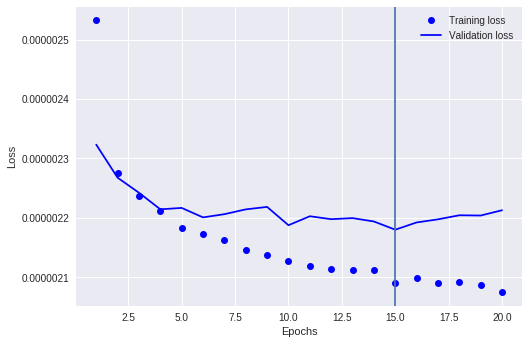

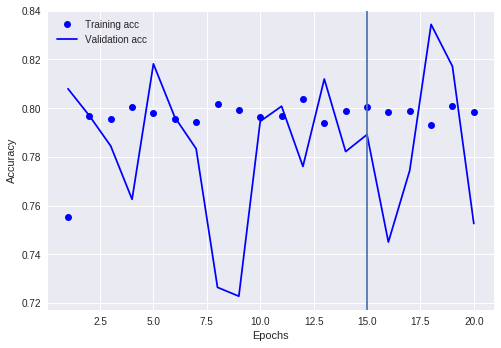

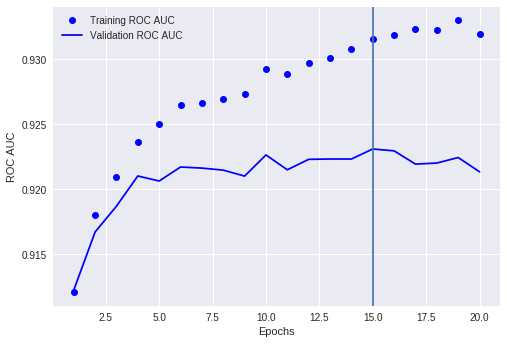

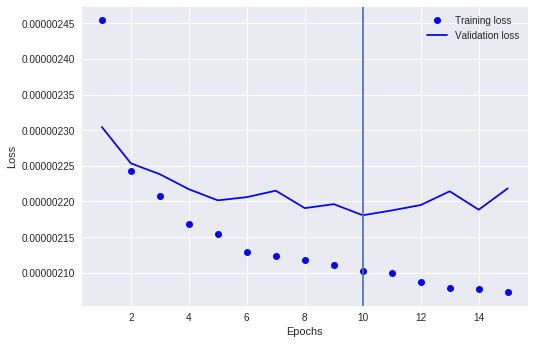

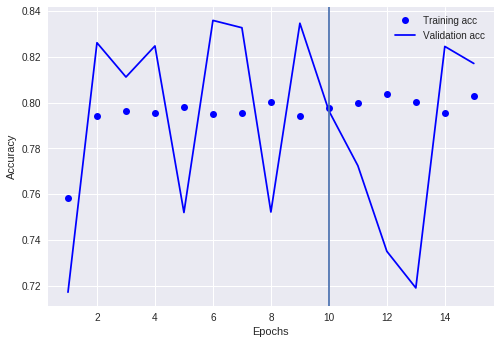

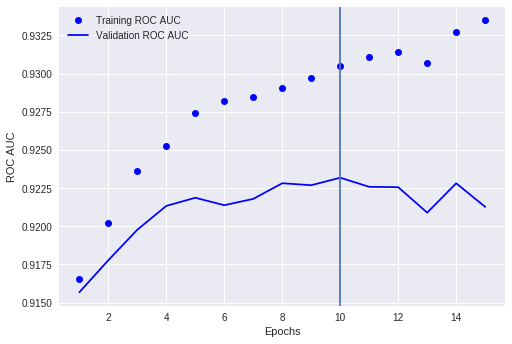

In [16]:
model64.plotTrainingValidation()
model128.plotTrainingValidation()

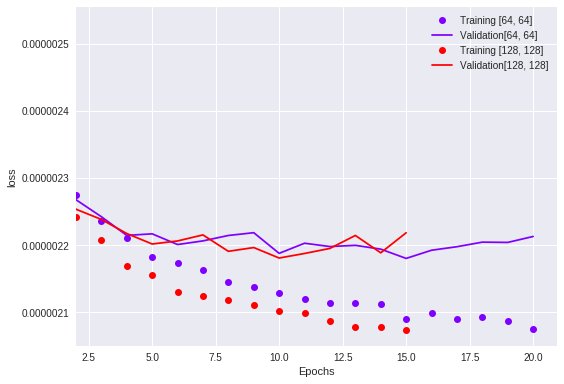

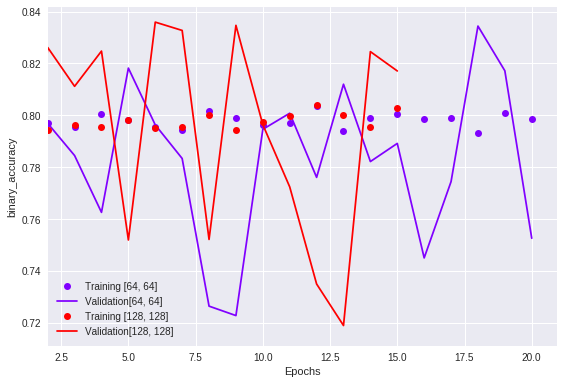

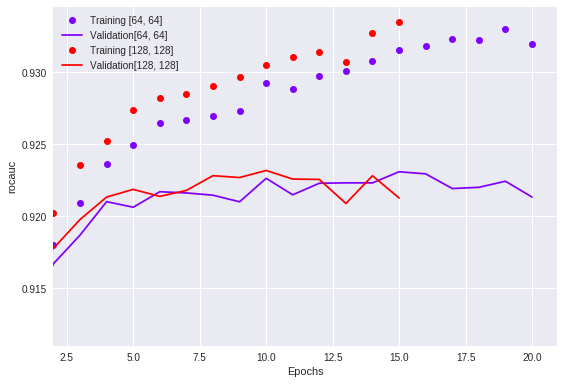

In [17]:
models={
    str([64,64]): model64,
    str([128,128]): model128
}
def plotByConfiguration(configurations=[[64,64],[128,128]], variable="loss", validationvariable="val_loss"):
  color=iter(plt.cm.rainbow(np.linspace(0,1,len(configurations))))
  
  if variable=="rocauc":
    index=-1
    for i,cb in enumerate(models[str(configurations[0])].callbacks):
      if hasattr(cb, 'roc') and hasattr(cb, 'roc_val'):
        index=i
  
  plt.figure()
  for configuration in configurations:

    if variable=="rocauc":
      loss_values=models[str(configuration)].callbacks[i].roc
      val_loss_values=models[str(configuration)].callbacks[i].roc_val
    else:
      loss_values=models[str(configuration)].history.history[variable]
      val_loss_values=models[str(configuration)].history.history[validationvariable]
    epochs=range(1,len(loss_values)+1)
    c=next(color)
    plt.plot(epochs, loss_values,"o", color=c,label="Training "+str(configuration))
    plt.plot(epochs, val_loss_values, color=c, label="Validation"+str(configuration))
    
  plt.xlim(left=2)
  plt.xlabel("Epochs")
  plt.ylabel(variable)
  plt.tight_layout()
  plt.legend()
  
 
plotByConfiguration()
plotByConfiguration(variable="binary_accuracy", validationvariable="val_binary_accuracy")
plotByConfiguration(variable="rocauc")

let's have a quick look if those parameters are roughly ok for mH+=800 GeV

In [29]:
#print(hpmass_train.unique())
def prepareDS(hpmass,X,y,w,hpmasses):
    mask=(hpmasses==hpmass) | (hpmasses<=0)
    X_new=X.copy()
    X_new["hpmass"]=(hpmass-hpmass_mean)/hpmass_scale
    return X_new[mask], y[mask], w[mask]
#print(sorted(X_test.hpmass.unique()))

[1600  350 2000  400  500  225   -1 1200  275 1400  200  900  700  250
  800 1800  600  300 1000]
[-1.714399943895742, -1.6693235574254586, -1.6242471709551751, -1.5791707844848917, -1.534094398014608, -1.4439416250740411, -1.3537888521334742, -1.1734833062523402, -0.9931777603712062, -0.8128722144900722, -0.6325666686089382, -0.4522611227278042, -0.2719555768466702, 0.08865551491559776, 0.4492666066778657, 0.8098776984401337, 1.1704887902024017, 1.5310998819646697]


## Evaluating the classifier for all H+ masses

In [0]:
hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]

In [0]:
print("1-ROC AUC for different masses in 6j4b - test, train")

trainvalues=[]
testvalues=[]

for hpmass in hpmasses:
    X_testfilter, y_testfilter, w_testfilter=prepareDS(hpmass,X_test,y_test,w_test, )
    X_trainfilter, y_trainfilter, w_trainfilter=prepareDS(hpmass,X_test,y_test,w_test, )
    #X_trainfilter[hpmass], X_testfilter[hpmass], _, y_trainfilter[hpmass], y_testfilter[hpmass],_, w_trainfilter[hpmass], w_testfilter[hpmass], _=htf.prepare(hpmass=hpmass,addMass=True)
    #X_trainfilter[hpmass].hpmass=hpmass
    #X_testfilter[hpmass].hpmass=hpmass
  
    #opt=HpHyperParameterOptimisation.HpOptimise("massparBDT"+str(hpmass),clf,X_trainfilter[hpmass],y_trainfilter[hpmass],w_trainfilter[hpmass],X_testfilter[hpmass],y_testfilter[hpmass],w_testfilter[hpmass])
    #test,train=opt.test(X_trainfilter[hpmass], y_trainfilter[hpmass], w_trainfilter[hpmass], X_testfilter[hpmass], y_testfilter[hpmass], w_testfilter[hpmass])
    #trainvalues.append(train)
    #testvalues.append(test)

    print(hpmass, test, train)

1-ROC AUC for different masses in 6j4b - test, train
200 0.4011469480916192 0.3644767907829588
225 0.3849203524999285 0.3577502707493533
250 0.3864955410629486 0.3521328750854189
275 0.3763293520377168 0.3447275526246004
300 0.3545841578296772 0.325809739960205
350 0.3351679054407206 0.3091548026001506
400 0.30485595459837267 0.2700961136997314
500 0.2408181536372972 0.22374171119676312
600 0.19507217954115197 0.17671526580526276
700 0.15348591703588998 0.13359804214552307
800 0.1208438797913558 0.10440766711986726
900 0.09521943757425966 0.08654821067066087
1000 0.0804955957725988 0.06788601382150805
1200 0.050919810882050554 0.041390936089027885
1400 0.03673054946239207 0.028688534041148794
1600 0.02756450759422524 0.021054619560335164
1800 0.020744680667706628 0.01449729598142091
2000 0.015146068695355064 0.011350278335399366


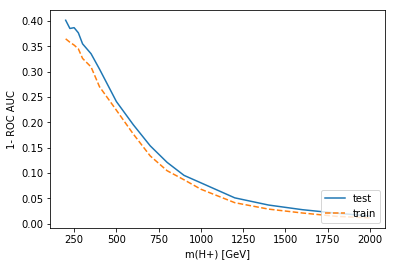

In [0]:
plt.plot(hpmasses, testvalues, '-', label='test')
plt.plot(hpmasses, trainvalues, '--', label='train')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")

There is basically no overtraining --> we can probably win a bit of sensitivity by moving towards a higher number of trees and more depth or lower learning rate

## Optimising the hyperparameters for m(H+)=800 GeV
and hoping it holds independently

In [0]:
X_test800,y_test800,w_test800=prepareTestDS(800,X_test,y_test,w_test)

Validation curve for learning_rate
Training for  0.05
Training for  0.1
Training for  0.13
Training for  0.2
Training for  0.5
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDT800_learning_rate_criterionfriedman_mse_initNone_learning_rate05_lossdeviance_max_depth5_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators120_n_iter_no_changeNone_presortauto_random_state0_subsample10_tol00001_validation_fraction01_verbose0_warm_startFalse.png
Validation curve for max_depth
Training for  3
Training for  4
Training for  5
Training for  6
Saving plot as  validationcurve_GradientBoostingClassifier_massparBDT800_max_depth_criterionfriedman_mse_initNone_learning_rate05_lossdeviance_max_depth6_max_featuresNone_max_leaf_nodesNone_min_impurity_decrease00_min_impurity_splitNone_min_samples_leaf1_min_samples_split2_min_weight_fraction_leaf001_n_estimators120_n_iter_no_changeNon

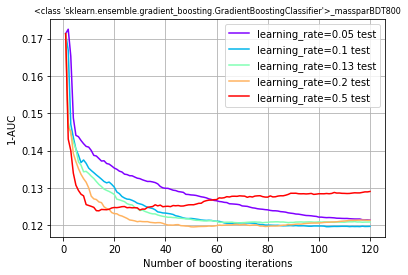

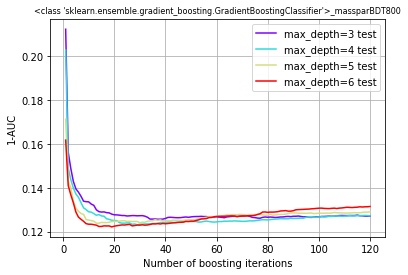

In [0]:
hpopt=HpHyperParameterOptimisation.HpOptimise("massparBDT800",clf,X_train,y_train,w_train,X_test800,y_test800,w_test800)
hpopt.saveAllValidationCurves()

## Training the classifier at N-1 masses and checking at the remaining mass

In [0]:
from scipy.stats import rv_discrete
sb=HpMLUtils.MultiSBWeightsScaler(backgroundclass=-1)

trainvalues_cross=[]
testvalues_cross=[]
for hpmass in hpmasses:
    X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass, addMass=True, invertsignal=True)
    sb.fit(X_train,X_train.hpmass, sample_weight=w_train)
    X_train=sb.transform(X_train,X_train.hpmass, sample_weight=w_train)

    signalsum=w_train[X_train.hpmass>0].sum()
    xk=[]
    pk=[]
    for name, group in w_train.groupby(X_train.hpmass):
        if name>0:
            xk.append((-1)*name)
            pk.append(group.sum()/signalsum)
    
    custm=rv_discrete(values=(xk,pk))
    X_train["hpmass"]=X_train.hpmass.apply(lambda x: x if x>0 else custm.rvs())
    X_train.hpmass=X_train.hpmass.abs()
    
    clf=HpAlgorithms.getGradientBDTClassifier()
    clf.fit(X_train, y_train, sample_weight=w_train)
    #write the results into a file
    dump(clf, 'massparameterisedBDT_allbut'+str(hpmass)+'.joblib')
    
    X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval =htf.prepare(hpmass=hpmass, addMass=True, invertsignal=False)
    
    #X_testfilter[hpmass],y_testfilter[hpmass],w_testfilter[hpmass]=prepareTestDS(hpmass,X_test,y_test,w_test)
    X_test["hpmass"]=hpmass
    X_train["hpmass"]=hpmass
    opt=HpHyperParameterOptimisation.HpOptimise("massparBDT"+str(hpmass),clf,X_train,y_train,w_train,X_test,y_test,w_test)
    test,train=opt.test(X_train, y_train, w_train, X_test, y_test, w_test)
    trainvalues_cross.append(train)
    testvalues_cross.append(test)
    print(hpmass, test, train)

200 0.43673735170651506 0.4126903789815606
225 0.3929722288813289 0.3662028756307024
250 0.3903737298911084 0.36088926473649263
275 0.3673398181907982 0.34151799809989214
300 0.36693701873751605 0.34328259353130564
350 0.33982381404566564 0.31942548885489286
400 0.31554823625273976 0.28225418103895994
500 0.260831640932754 0.24803859750421886
600 0.20511817099909557 0.18987932389170192
700 0.15329476976501588 0.13806379671397173
800 0.12580399151485766 0.11110017676525719
900 0.09727954874565459 0.08744587703757545
1000 0.08134010879804421 0.07000894530030644
1200 0.053418588216892604 0.04341228575117939
1400 0.037481024114641714 0.030620146993082797
1600 0.02797451870706602 0.022414747808154223
1800 0.021555851404670978 0.015339261903437595
2000 0.016534031434481178 0.012269512118769477


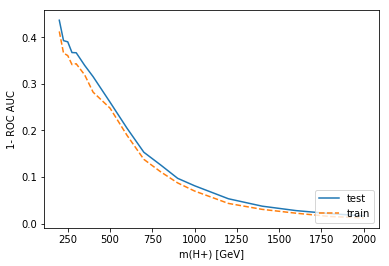

In [0]:
plt.plot(hpmasses, testvalues_cross, '-', label='test')
plt.plot(hpmasses, trainvalues_cross, '--', label='train')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

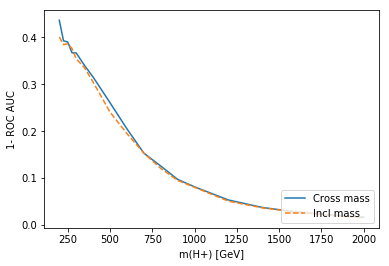

In [0]:
plt.plot(hpmasses, testvalues_cross, '-', label='Cross mass')
plt.plot(hpmasses, testvalues, '--', label='Incl mass')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

--> It seems that leaving out one mass point in between almost makes no difference (exception: 200 GeV, but that's not really a surprise)

### let's see how this converts to the default BDT

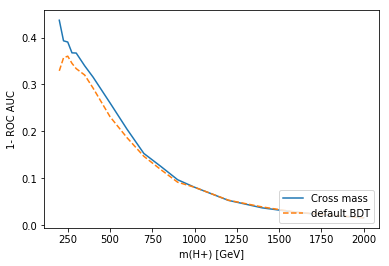

In [0]:
testdefaultBDT=[0.3290841140322679, 0.3566890794845421, 0.3602662115193581, 0.34498428916467183, 0.33375748714257425, 0.32019286312547357, 0.29225728165594855, 0.23146437865390979, 0.18697956512088676, 0.14718158177504637, 0.11895855659790655, 0.09204235231427149, 0.08130798049109356, 0.05375180442290828, 0.039379786382951254, 0.028362194212484093, 0.022254177247589824, 0.0160571366514084]
plt.plot(hpmasses, testvalues_cross, '-', label='Cross mass')
plt.plot(hpmasses, testdefaultBDT, '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('1- ROC AUC')
plt.legend(loc="lower right")
plt.show()

and how about cross section limit

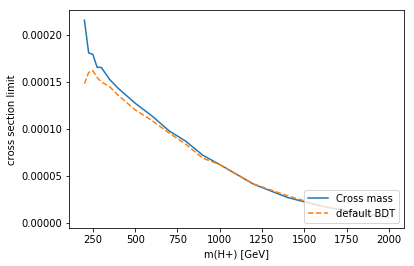

No handles with labels found to put in legend.


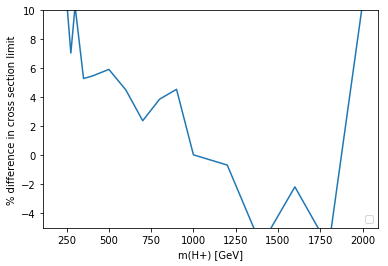

In [0]:
z=[ 5.84983620e-03, -4.16702246e-03,  1.22938606e-03, -1.36789294e-05] #fit values for ROC AUC to cross section limit comparison
f=np.poly1d(z)
plt.plot(hpmasses, f(testvalues_cross), '-', label='Cross mass')
plt.plot(hpmasses, f(testdefaultBDT), '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('cross section limit')
plt.legend(loc="lower right")
plt.show()

#and not %difference
plt.plot(hpmasses, (f(testvalues_cross)/f(testdefaultBDT)-1)*100, '-')
#plt.plot(hpmasses, f(testdefaultBDT), '--', label='default BDT')
plt.xlabel('m(H+) [GeV]')
plt.ylabel('% difference in cross section limit')
plt.legend(loc="lower right")
plt.ylim((-5,10))
plt.show()


one problem with the BDT is probably that the BDT score per event is not exactly smooth (probably quite ok as the distribution should be pretty smooth)

In [0]:
def decisionfunction(eventnumber):
    testmasses=np.linspace(200,2000, 1801)
    line1=X_test.iloc[eventnumber].copy()
    df = pd.DataFrame([line1]*len(testmasses))
    df["hpmass"]=testmasses
    y_pred=clf.decision_function(df)
    y_pred[:5]
    plt.plot(testmasses, y_pred, '-')
    plt.xlabel('m(H+) [GeV]')
    plt.ylabel('BDT score')
    #plt.legend(loc="lower right")
    plt.show()

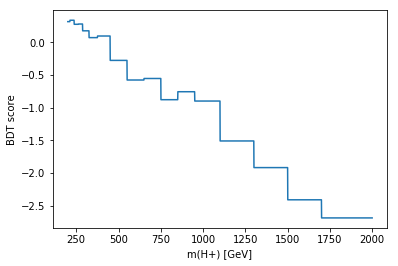

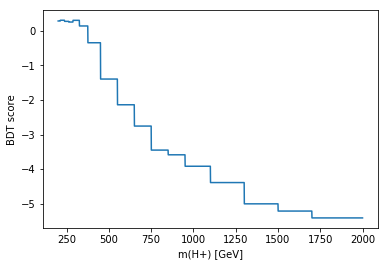

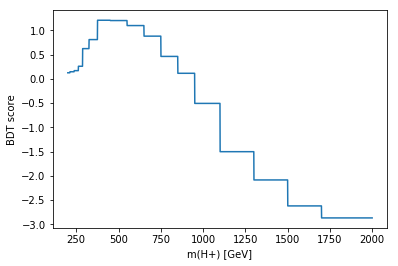

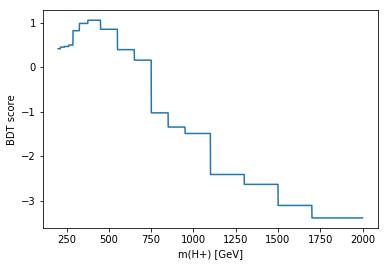

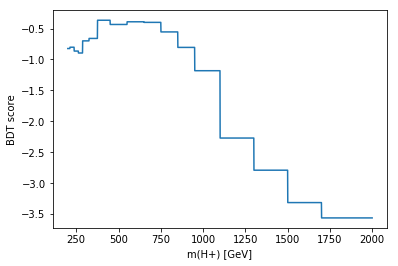

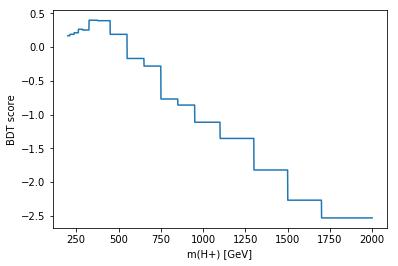

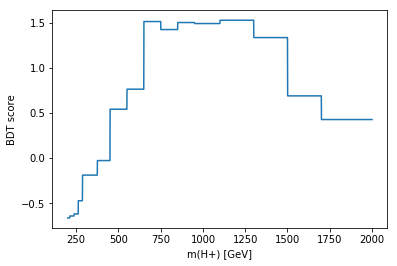

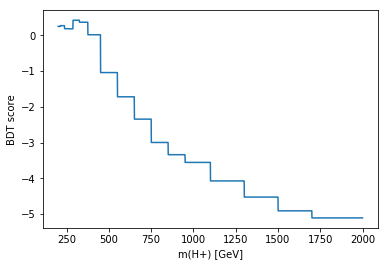

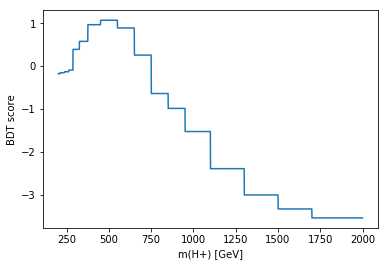

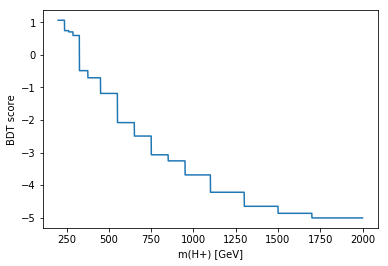

In [0]:
for i in range(0,10):
    decisionfunction(i)